In [1]:
# import matplotlib.pyplot as plt 

# import scipy.ndimage.filters
# import scipy.stats

# from skimage.transform import pyramid_laplacian

# from PIL import Image
# from PIL import ImageFilter

# import numpy as np

import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
from PIL import ImageFilter
from scipy import ndimage

import cPickle

from sklearn import linear_model, datasets

%matplotlib inline

/usr/lib/python2.7/dist-packages/pkg_resources/__init__.py:1224: UserWarning: /home/brendan/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


(750, 1000, 3) (750, 1000, 3) (750, 1000, 3)


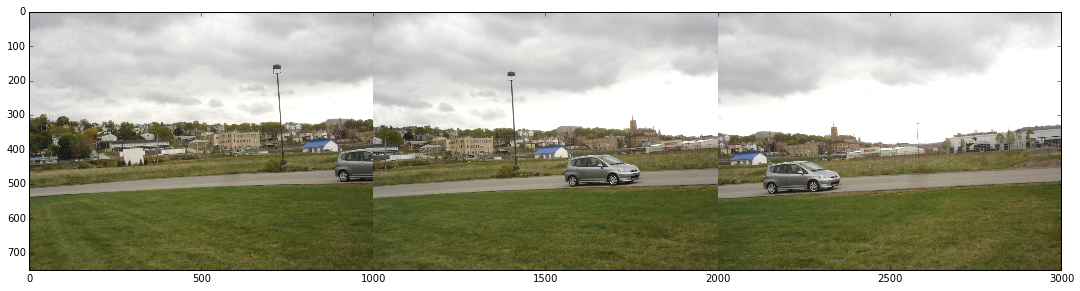

In [2]:
'''
VEIWING
'''

one = np.asarray(Image.open("Images/Q2/Working set/I1.jpg"),dtype=np.float64)/255.0
two = np.asarray(Image.open("Images/Q2/Working set/I2.jpg"),dtype=np.float64)/255.0
three = np.asarray(Image.open("Images/Q2/Working set/I3.jpg"),dtype=np.float64)/255.0

print one.shape, two.shape, three.shape

# combining images
ipan = np.concatenate((one, two, three), axis =1)

f=plt.figure()
f.set_size_inches(18.5, 10.5)

plt.imshow(ipan)
# plt.figure()
# plt.imshow(two)
# plt.figure()
# plt.imshow(three)
# plt.figure()

In [3]:
'''
DETECTION
Finding feature vectors. Because of library shenanigans, we had to run this on a machine (linux box) that 
didn't have such a hard time installing opencv. In addition, SIFT didn't seem to work because of the
version of opencv that we did get sucessfully installed. So we did some research and decided to user the newer 
(2014) BRISK feature detection as opposed to the propriatary SIFT (1999). This was easier to use and allowed us to 
extract the features from all the images and store them to a pickle file so both partners could use their own device.
'''
# import cv2, cPickle
# img=cv2.imread("Images/Q2/Working set/I1.jpg")
# img2=cv2.imread("Images/Q2/Working set/I2.jpg")
# img3=cv2.imread("Images/Q2/Working set/I3.jpg")
# def extract_features(img):
#     gray_one=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     brisk=cv2.BRISK()
#     features=brisk.detect(gray_one,None)
#     # print(features[0].pt)
#     real_features=map(lambda x: x.pt,features)
#     return real_features
# test=extract_features(img)
# cPickle.dump(extract_features(img),open("feats1.p","w+b"))
# cPickle.dump(extract_features(img2),open("feats2.p","w+b"))
# cPickle.dump(extract_features(img3),open("feats3.p","w+b"))
# test2=cPickle.load(open("feats1.p","rb"))
# print(test==test2)
#     img=cv2.drawKeypoints(gray_one,features)
#     f=plt.figure()
#     f.set_size_inches(18.5, 10.5)
#     plt.imshow(img,cmap="Greys_r")
feat1 = cPickle.load(open("feats1.p","rb"))
feat2 = cPickle.load(open("feats2.p","rb"))
feat3 = cPickle.load(open("feats3.p","rb"))

feat1 = np.asarray(feat1)
feat2 = np.asarray(feat2)
feat3 = np.asarray(feat3)

print feat1.shape, feat2.shape, feat3.shape

(679, 2) (645, 2) (454, 2)


In [4]:
'''
MATCHING
'''

def matching(feat1, feat2):
    matched = []
    for p1 in feat1:  
        #making sure feat2 is np array to be able to take argmin        
        feat2 = np.array(feat2)
        dist = []
        if len(feat2) == 0: 
            break
        else:
            for p2 in feat2:
                # Euclidean distance calculation
                dist.append(np.linalg.norm( abs(p1-p2) ))
            ind = np.argmin(dist, axis = 0)
            matched.append( np.ndarray.flatten( np.array([p1, feat2[ind]]) ))
#             print [p1, feat2[ind]]
            #removing element from np list by converting back to python list                         
            feat2 = np.ndarray.tolist(feat2)
            feat2.pop(ind)
    return matched
            
matched = matching(feat1, feat2)


In [5]:
points =  np.transpose(np.array(matched))
x1, y1, x2, y2 = points[0], points[1], points[2], points[3]
x2 += one.shape[1]

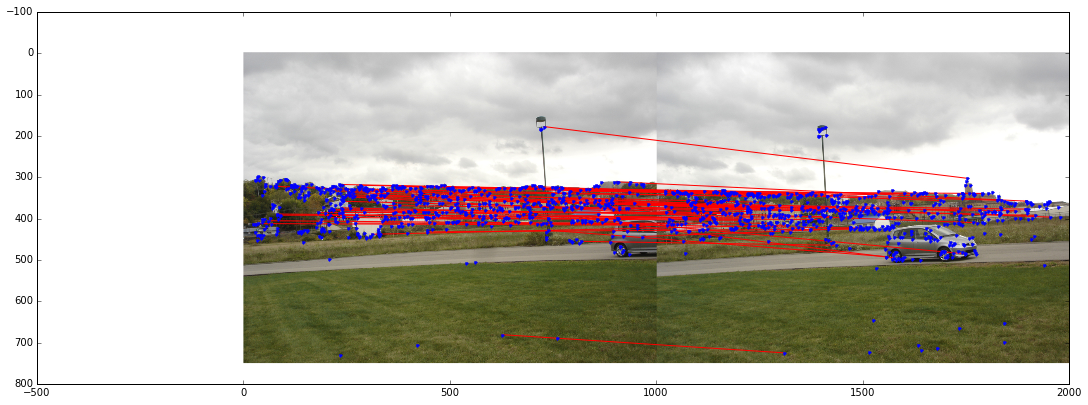

In [25]:
# a=[[1,2],[3,3],[4,4],[5,2]]  *zip(*a)

twoimg = np.concatenate((one, two), axis =1)

f=plt.figure()
f.set_size_inches(18.5, 10.5)
plt.imshow(twoimg)

# plt.plot( [x1[0], x2[0]], [y1[0], y2[0]] , linestyle = "-", linewidth = "2", marker='.', color='r', ls='')
# plt.plot([x1[0], x2[0]], [y1[0], y2[0]] , '-o')

for n in range(0, 645, 13):
    plt.plot( [x1[n], x2[n]], [y1[n], y2[n]] ,'r-' )

for n in range(len(x1)):
    plt.plot( [x1[n], x2[n]], [y1[n], y2[n]] ,'b.' )

#     linestyle = "-", linewidth = "2", marker='.', color='r', ls=''

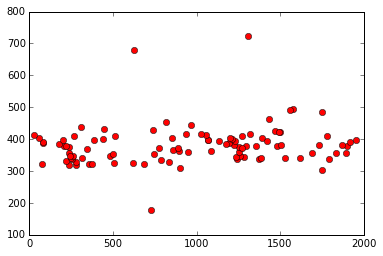

In [7]:
for n in range(0, 645, 13):
    plt.plot( [x1[n], x2[n]], [y1[n], y2[n]] ,'ro' )

(1290, 1) (1290, 1)
Estimated coefficients (true, normal, RANSAC):
[[ 0.03841101]]


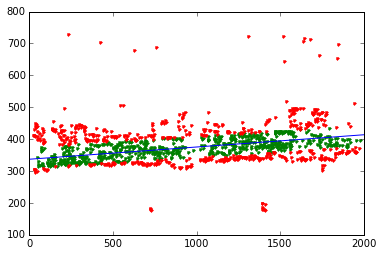

In [8]:
'''
HOMOGRAPHY

Prt.1 RANSAC
'''

# 
X = np.ndarray.flatten( np.array([x1, x2]) )
Y = np.ndarray.flatten( np.array([y1, y2]) )

x = X.reshape(-1,1)
y = Y.reshape(-1,1)

print x.shape, y.shape

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(x , y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
x_range = np.arange( 0 , one.shape[1]*2 )
line_y_ransac = model_ransac.predict(x_range[:, np.newaxis])

# Compare estimated coefficients
print("Estimated coefficients (true, normal, RANSAC):")
print(model_ransac.estimator_.coef_)

plt.plot(x[inlier_mask], y[inlier_mask], '.g', label='Inliers')
plt.plot(x[outlier_mask], y[outlier_mask], '.r', label='Outliers')
# plt.plot(line_X, line_y, '-k', label='Linear regressor')
plt.plot(x_range, line_y_ransac, '-b', label='RANSAC regressor')
# plt.legend(loc='lower right')
# plt.show()

# for n in range(0, 645, 13):
#     plt.plot( [x1[n], x2[n]], [y1[n], y2[n]] ,'ro' )


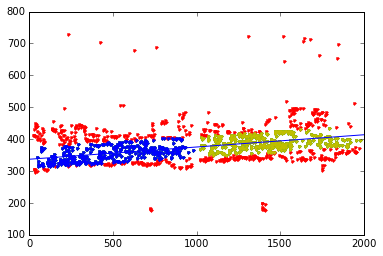

In [9]:
# seperating inliers into subgroups
inliers = np.concatenate(  (x[inlier_mask], y[inlier_mask]), axis =1)
group1 = inliers[ inliers[:,0] <= one.shape[1] ]
group2 = inliers[ inliers[:,0] > one.shape[1] ]

plt.plot(x[inlier_mask], y[inlier_mask], '.g', label='Inliers')
plt.plot(x[outlier_mask], y[outlier_mask], '.r', label='Outliers')
plt.plot( group1[:,0], group1[:,1], '.b')
plt.plot( group2[:,0], group2[:,1], '.y')
# plt.plot(line_X, line_y, '-k', label='Linear regressor')
plt.plot(x_range, line_y_ransac, '-b', label='RANSAC regressor')

In [10]:
import cv2
def even_groups(g1,g2):
    if g1.shape[0]>g2.shape[0]:
        g1=g1[:g2.shape[0]]
    else:
        g2=g2[:g1.shape[0]]
    return (g1,g2)
group1,group2= even_groups(group1,group2)
print(group1.shape)
print(group2.shape)
homo=cv2.findHomography(group1,group2,cv2.RANSAC)

(334, 2)
(334, 2)


[ 729.26306152  177.19857788]


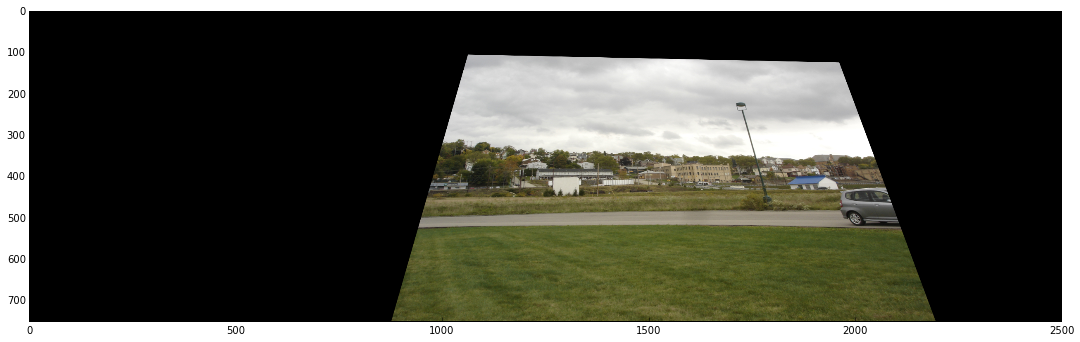

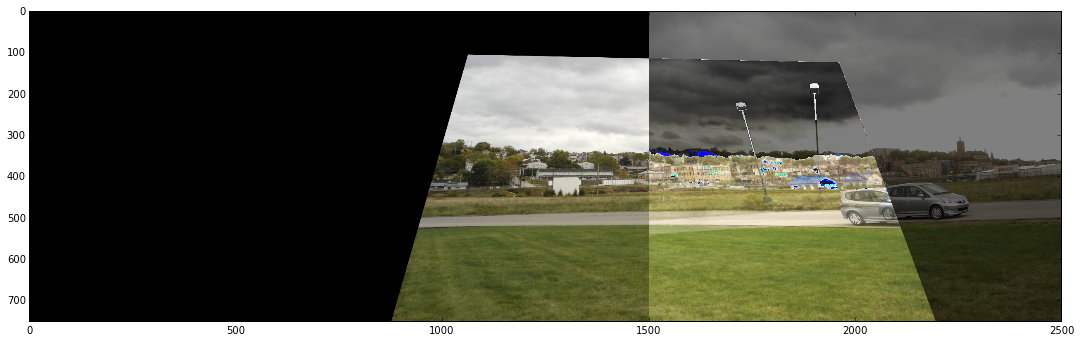

In [46]:
'''
MAPPING
'''
# print(np.atleast_2d(x1).shape)
groupone=np.vstack((x1,y1))
grouptwo=np.vstack((x2,y2))
groupone,grouptwo=even_groups(groupone,grouptwo)
groupone=np.transpose(groupone)
grouptwo=np.transpose(grouptwo)
homo2=cv2.findHomography(groupone,grouptwo,cv2.RANSAC,3)

print(groupone[0])

# homo3=np.transpose(homo2[0])
# print(homo2[0])
# print(homo[0])
# new_image = np.zeros((one.shape[0]*2,one.shape[1]*2))
output=cv2.warpPerspective(one,homo2[0],dsize=(int(one.shape[1]*2.5),one.shape[0]))
# output=cv2.warpPerspective(one,homo3,dsize=(one.shape[0],int(one.shape[1]*2.5)))

f1=plt.figure()
f1.set_size_inches(18.5, 10.5)
plt.imshow(output)
shifted_two=np.concatenate((np.zeros((750,1500,3)),two),axis=1)
thing=output+shifted_two/2.0
f=plt.figure()
f.set_size_inches(18.5, 10.5)

plt.imshow(thing)
# print(one.shape)


